In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import openai
import yaml

from utils import *

import autoKG_full as AKG

In [3]:
with open("config.yaml", 'r') as stream:
    try:
        params = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)


COMPLETIONS_MODEL = params["OPENAI_API_MODEL"]
EMBEDDING_MODEL = params["EMBEDDING_MODEL"]
my_api_key = params["OPENAI_API_KEY"]
openai.api_key = my_api_key

os.environ['OPENAI_API_KEY'] = my_api_key
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

In [4]:
directory = "raw_data"
texts, sources = load_and_process_files(directory,
                                        chunk_size=200,
                                        separator=None)



In [5]:
main_topic = "Random Feature Models, High-dimensional PDEs, Bayesian Inverse Problems, MCMC, Data-driven Scientific Computing"

KG_class = AKG.autoKG(texts=texts,
                         source=sources,
                         embedding_model=EMBEDDING_MODEL,
                         llm_model=COMPLETIONS_MODEL,
                         openai_api_key=OPENAI_API_KEY,
                         main_topic=main_topic,
                         embedding=True)

In [6]:
# step one: remove duplicates
to_keep, to_delete, remains = KG_class.remove_same_text(use_nn=True, n_neighbors=25, thresh=1e-6, update=True)
print(len(to_keep))

2027


In [7]:
# step two: extract keywords with two methods
core_list_1, all_tokens = KG_class.cluster(15,
                               clustering_method='NgJordanWeiss',
                               max_texts=15,
                               select_mtd='similarity',
                               prompt_language='English',
                               num_topics=10,
                               max_length=3,
                               post_process=True,
                               add_keywords=False,
                               verbose=False)
print("Number of keywords selected:", len(core_list_1))
print("Token used:", all_tokens)

core_list_2, all_tokens = KG_class.cluster(15,
                               clustering_method='k_means',
                               max_texts=15,
                               select_mtd='similarity',
                               prompt_language='English',
                               num_topics=10,
                               max_length=3,
                               post_process=True,
                               add_keywords=True)
print("Number of keywords selected:", len(core_list_2))
print("Token used:", all_tokens)

print("Number of keywords:", len(KG_class.keywords))

Before Post Process: 140
After Post Process: 140
Number of keywords selected: 140
Token used: 53202
Before Post Process: 141
After Post Process: 134
Number of keywords selected: 134
Token used: 56225
Number of keywords: 244


In [8]:
_ = KG_class.sub_entry_filter()
print("Number of keywords:", len(KG_class.keywords))

Number of keywords: 231


In [9]:
_, all_tokens = KG_class.final_keywords_filter()
print("Token used:", all_tokens)
print("Number of keywords:", len(KG_class.keywords))


Token used: 6697
Number of keywords: 228


In [10]:
KG_class.make_graph(30)
pred_mat, U_mat, A = KG_class.coretexts_seg_individual(k=30, trust_num=5, negative_multiplier=7, seg_mtd='laplace',
                                                return_mat=True, connect_threshold=0.2)

In [11]:
KG_class.get_dist_mat()
print(KG_class.check_completion())

True


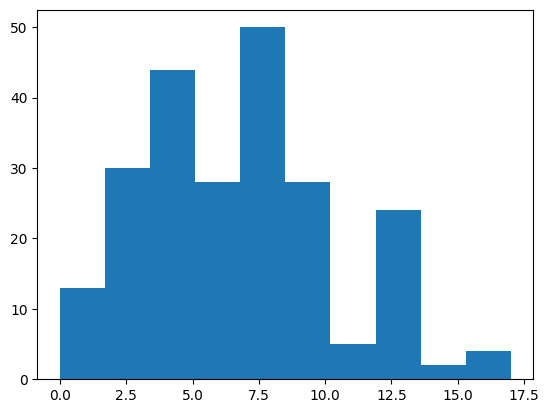

In [12]:
deg_mat = np.sum(np.array(A.todense()) > 0, axis=0)
plt.hist(deg_mat)
plt.show()

In [13]:
KG_class.save_data(os.path.join('KG_data', 'ref_paper_KG.npy'), include_texts=True)


Successfully save to KG_data/ref_paper_KG.npy


In [14]:
print(KG_class.keywords)

['Random expansions', ' Localization techniques', ' Parametric PDEs', ' pCN algorithm', ' Deep convolutional networks', ' Stochastic differential equations', ' Collocation points', ' Stochastic dynamical systems', ' Orthonormal basis', ' Adaptive preconditioning', ' Mori-Zwanzig formalism', ' Scale separation', ' Coarse time-stepping', ' Nonlinear approximation', ' Importance sampling', ' Fourier transform', ' Gaussian solutions', ' PDE discretization', ' Nonlinear PDEs', ' Numerical experiments', ' Dimension reduction', ' Second moment', ' Blocking strategies', ' Ensemble size effects', ' Invariant measure', ' Entropy decay', ' Data-driven', ' Bayesian inference', ' Operator regression', ' Markov chains', ' Super-resolution', ' Neural network approximation', ' Parametric operators', ' Gaussian priors', ' Autocorrelation time', ' Function-space samplers', ' Stokes flow', ' Quadratic norms', ' Trace-class condition', ' Supervised learning', ' Subspace approximation', ' Resolution', ' Co